<a href="https://colab.research.google.com/github/Alexandra-Smith/FruitPunch_AI_Bootcamp/blob/main/FP_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Poachers detection challenge for FP AI in Practice Bootcamp

by Alexandra Smith

In [1]:
import os
import matplotlib.pyplot as plt
import numpy
import tensorflow as tf
import numpy as np
import cv2

# Step 0
## Loading the data

In [2]:
# Connect directory to notebook and navigate to where data is stored

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# path to data within drive
DATA_PATH = '/content/drive/MyDrive/Poacher detection/Labeled data/'
IMAGE_PATH = DATA_PATH + 'images/'
LABELS_PATH = DATA_PATH + 'annotations/'

In [4]:
# Get paths to IMAGE directories
TRAIN_IMAGES_PATH = IMAGE_PATH + 'train/'
TEST_IMAGES_PATH = IMAGE_PATH + 'test/'
VAL_IMAGES_PATH = IMAGE_PATH + 'val/'

# Step 1
## Analysing the data

### Images

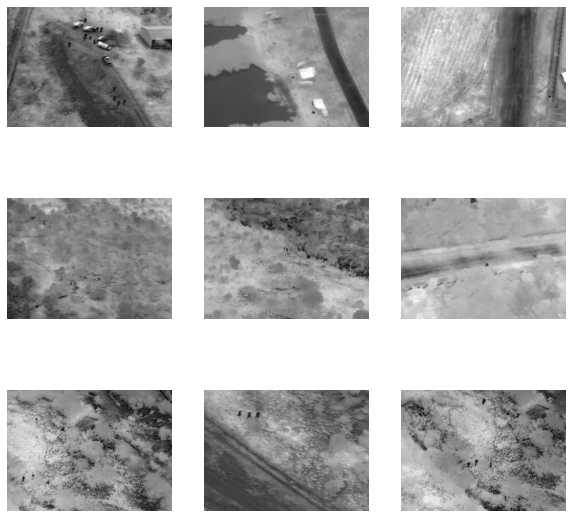

In [8]:
# View some train images
plt.figure(figsize=(10, 10))
TRAIN_IMAGES = os.listdir(TRAIN_IMAGES_PATH)
for i in range(9):
  img_path = TRAIN_IMAGES_PATH + TRAIN_IMAGES[i]
  ax = plt.subplot(3, 3, i + 1)
  img = cv2.imread(img_path, )
  plt.imshow(img, cmap='gray')
  plt.axis("off")

### Annotations

In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO

# Step 2
## Model

In [ ]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0,
#   subset="training",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)